In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import glob
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader 
from torch_geometric.nn import DynamicEdgeConv  
from torch_geometric.nn.aggr import AttentionalAggregation 
from tqdm import tqdm
import matplotlib.pyplot as plt
import warnings

DATA LOADING

In [3]:
def load_jets_from_npz(folder_path):

    all_files = sorted(glob.glob(f"{folder_path}/*.npz"))
    print(f"Number of files: {len(all_files)}")
    
    jet_list = []
    label_list = []
    
    for file in all_files:
        data = np.load(file)
  
        X_file = data["X"]
        y_file = data["y"]
        

        for jet, label in zip(X_file, y_file):
            jet_list.append(jet)
            label_list.append(label)
    
    return jet_list, label_list

folder_path = "data/"
X, y = load_jets_from_npz(folder_path)


Number of files: 5


**DATA PREPROCESSING**

**Markdown Cell:**

In this cell, we define the `preprocess_data` function to transform our raw jet data into a uniform format for modeling. Specifically:

- **PDG Dictionaries**: We keep two dictionaries (`pdg_to_index` and `pdg_charge_dict`) to map PDG IDs to:
  - Integer indices (for embedding purposes).
  - Their respective charges \((-1, 0, +1)\).

- **Logarithmic Transformation**: If `use_log_pt=True`, we apply a log transform to \(p_T\) for better numerical stability and dynamic range.

- **Centering (η, φ)**: If `center_method="hardest"`, we shift \(\eta\) and \(\phi\) so that the most energetic particle in each jet (i.e., the highest \(p_T\)) becomes the origin \((0,0)\). This focuses the model on relative particle positions within the jet.

- **Feature Assembly**: We create a final array of shape \((n_{\text{particles}}, 5)\) for each jet, stacking:
  1. \(p_T\) (optionally log-transformed),
  2. Centered \(\eta\),
  3. Centered \(\phi\),
  4. PDG index (for embedding),
  5. Charge (integer \(-1,0,1\)).

- **Return**: We build a list of processed jets, each with these 5 features, and return it along with the original labels (`y_labels`).

This preprocessing ensures that each jet is ready for our graph-based classification network, preserving relevant physics information (like the charge and relative positions) while normalizing the data for more stable training.

In [4]:
def preprocess_data(X, y, use_log_pt=True, center_method="hardest", apply_mask=True):

    pdg_to_index = {
        22: 0,    # photon
        211: 1,   # pi+
        -211: 2,  # pi-
        130: 3,   # K0L
        321: 4,   # K+
        -321: 5,  # K-
        2212: 6,  # proton
        -2212: 7, # antiproton
        2112: 8,  # neutron
        -2112: 9, # antineutron
        11: 10,   # electron
        -11: 11,  # positron
        13: 12,   # muon-
        -13: 13,  # muon+
        15: 14,   # tau-
        -15: 15,  # tau+
        24: 16,   # W+
        -24: 17   # W-
    }
    pdg_charge_dict = {
        22: 0,
        211: 1,
        -211: -1,
        130: 0,
        321: 1,
        -321: -1,
        2212: 1,
        -2212: -1,
        2112: 0,
        -2112: 0,
        11: -1,
        -11: 1,
        13: -1,
        -13: 1,
        15: -1,
        -15: 1,
        24: 1,
        -24: -1
    }
    
    processed_list = []
    
    for jet in X:
   
        pt  = jet[:, 0].copy()   # pT
        eta = jet[:, 1].copy()   # eta
        phi = jet[:, 2].copy()   # phi
        pdg = jet[:, 3].copy()   # pdgID
        
        mask = pt > 0
        
        if use_log_pt:
            pt = np.log(pt + 1e-9)
        
        if center_method == "hardest":
            valid_indices = np.where(mask)[0]
            if valid_indices.size > 0:
                max_idx = valid_indices[np.argmax(jet[valid_indices, 0])]
                center_eta = eta[max_idx]
                center_phi = phi[max_idx]
                eta = eta - center_eta
                phi = phi - center_phi
        
        pdg_index = np.vectorize(lambda x: pdg_to_index.get(x, 0))(pdg)
        
        charge = np.vectorize(lambda x: pdg_charge_dict.get(x, 0))(pdg)
        
        processed_jet = np.stack([pt, eta, phi, pdg_index, charge], axis=-1)
        processed_list.append(processed_jet)
        
    return processed_list, y

particle_list, y_labels = preprocess_data(X, y, use_log_pt=True, center_method="hardest", apply_mask=True)


**DATA PREPARATION**

**Markdown Cell:**

We split our processed jet data into training and test sets using an 80/20 ratio, ensuring our model can be trained on one subset of jets while being evaluated on a different subset. Then, we define the `create_pyg_dataset` function, which converts each jet (and its label) into a PyTorch Geometric `Data` object. Each `Data` object contains:
- `x`: a tensor of shape \((\text{n_particles}, 5)\) with features such as \(p_T\), \(\eta\), \(\phi\), PDG index, and charge,
- `y`: an integer label indicating the class (e.g., quark vs. gluon).

By returning a list of these `Data` objects, we can easily feed them into a PyTorch Geometric `DataLoader` to handle batching, shuffling, and other training-related operations.

In [5]:
particle_train, particle_test, y_train, y_test = train_test_split(
    particle_list, y_labels, test_size=0.2, random_state=42
)

print("Number of jets in the training set:", len(particle_train))
print("Number of jets in the test set:", len(particle_test))

Number of jets in the training set: 400000
Number of jets in the test set: 100000


In [6]:
def create_pyg_dataset(particle_list, labels):
    data_list = []
    for jet, label in zip(particle_list, labels):
        x = torch.tensor(jet, dtype=torch.float)
        y = torch.tensor(label.astype(int), dtype=torch.long)
        data = Data(x=x, y=y)
        data_list.append(data)
    return data_list

**MODELLING**

This model, **ParticleNet**, uses DynamicEdgeConv layers to build a graph from particle features, then aggregates the node representations with an attention-based pooling. Each particle’s PDG ID is mapped to an embedding, and continuous features (\(p_T\), \(\eta\), \(\phi\), charge) are concatenated before passing through three EdgeConv blocks. The final node embeddings are aggregated via attention, and the resulting vector goes through fully connected layers for classification.

In [7]:
class ParticleNet(nn.Module):
    def __init__(self, k=8, continuous_dim=4, num_classes=2, pdg_vocab_size=18, embedding_dim=8):
        super(ParticleNet, self).__init__()
        self.pdg_embedding = nn.Embedding(num_embeddings=pdg_vocab_size, embedding_dim=embedding_dim)
        input_dim = 3 + 1 + embedding_dim
        self.edgeconv1 = DynamicEdgeConv(nn.Sequential(
            nn.Linear(2 * input_dim, 64),
            nn.ReLU(),
            nn.BatchNorm1d(64)
        ), k=k)
        self.edgeconv2 = DynamicEdgeConv(nn.Sequential(
            nn.Linear(2 * 64, 128),
            nn.ReLU(),
            nn.BatchNorm1d(128)
        ), k=k)
        self.edgeconv3 = DynamicEdgeConv(nn.Sequential(
            nn.Linear(2 * 128, 256),
            nn.ReLU(),
            nn.BatchNorm1d(256)
        ), k=k)
        self.att_pool = AttentionalAggregation( 
            gate_nn=nn.Sequential(
                nn.Linear(256, 128),
                nn.ReLU(),
                nn.Linear(128, 1)
            )
        )
        self.fc1 = nn.Linear(256, 128)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x, batch):
        continuous = x[:, [0, 1, 2, 4]]
        pdg_index = x[:, 3].long()
        pdg_emb = self.pdg_embedding(pdg_index)
        x = torch.cat([continuous, pdg_emb], dim=-1)
        x = self.edgeconv1(x, batch)
        x = self.edgeconv2(x, batch)
        x = self.edgeconv3(x, batch)
        x_pool = self.att_pool(x, batch)
        x_fc = F.relu(self.fc1(x_pool))
        x_fc = self.dropout(x_fc)
        out = self.fc2(x_fc)
        return out

**TRAIN & TEST**

We convert our training and test splits into PyTorch Geometric datasets, create DataLoader objects with a chosen batch size, and move everything to a GPU if available. The `train` function performs a forward/backward pass for each batch, computing the CrossEntropy loss and updating model parameters. The `test` function evaluates accuracy on a given DataLoader. We train the model for 30 epochs, tracking loss and accuracy on both training and test sets at the end of each epoch.

In [8]:
train_dataset = create_pyg_dataset(particle_train, y_train)
test_dataset  = create_pyg_dataset(particle_test, y_test)

batch_size = 128
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = ParticleNet().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

def train(epoch):
    model.train()
    total_loss = 0
    pbar = tqdm(train_loader, desc=f"Epoch {epoch} - Training", leave=False)
    for data in pbar:
        data = data.to(device)
        optimizer.zero_grad()
        out = model(data.x, data.batch)
        loss = criterion(out, data.y.view(-1))
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * data.num_graphs
        pbar.set_postfix(loss=loss.item())
    return total_loss / len(train_dataset)

def test(loader, phase="Test"):
    model.eval()
    correct = 0
    total = 0
    pbar = tqdm(loader, desc=f"{phase} Phase", leave=False)
    with torch.no_grad():
        for data in pbar:
            data = data.to(device)
            out = model(data.x, data.batch)
            pred = out.argmax(dim=1)
            correct += (pred == data.y.view(-1)).sum().item()
            total += data.num_graphs
            pbar.set_postfix(acc=correct/total if total > 0 else 0)
    return correct / total

num_epochs = 30
train_losses = []
train_accs = []
test_accs = []

for epoch in range(1, num_epochs+1):
    loss = train(epoch)
    train_acc = test(train_loader, phase="Train")
    test_acc = test(test_loader, phase="Test")
    
    train_losses.append(loss)
    train_accs.append(train_acc)
    test_accs.append(test_acc)
    
    print(f"Epoch: {epoch:02d}, Loss: {loss:.4f}, Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}")

Epoch: 01, Loss: 0.4637, Train Acc: 0.7952, Test Acc: 0.7941


Epoch: 02, Loss: 0.4378, Train Acc: 0.8106, Test Acc: 0.8111


Epoch: 03, Loss: 0.4263, Train Acc: 0.8175, Test Acc: 0.8164


Epoch: 04, Loss: 0.4184, Train Acc: 0.8200, Test Acc: 0.8189


Epoch: 05, Loss: 0.4123, Train Acc: 0.8247, Test Acc: 0.8233


Epoch: 06, Loss: 0.4076, Train Acc: 0.8269, Test Acc: 0.8249


Epoch: 07, Loss: 0.4052, Train Acc: 0.8280, Test Acc: 0.8261


Epoch: 08, Loss: 0.4029, Train Acc: 0.8288, Test Acc: 0.8260


Epoch: 09, Loss: 0.4012, Train Acc: 0.8284, Test Acc: 0.8262


Epoch: 10, Loss: 0.3991, Train Acc: 0.8306, Test Acc: 0.8277


Epoch: 11, Loss: 0.3983, Train Acc: 0.8313, Test Acc: 0.8276


Epoch: 12, Loss: 0.3963, Train Acc: 0.8330, Test Acc: 0.8292


Epoch: 13, Loss: 0.3959, Train Acc: 0.8324, Test Acc: 0.8287


Epoch: 14, Loss: 0.3947, Train Acc: 0.8347, Test Acc: 0.8303


Epoch: 15, Loss: 0.3935, Train Acc: 0.8356, Test Acc: 0.8313


Epoch: 16, Loss: 0.3925, Train Acc: 0.8369, Test Acc: 0.8326


Epoch: 17, Loss: 0.3913, Train Acc: 0.8371, Test Acc: 0.8317


Epoch: 18, Loss: 0.3906, Train Acc: 0.8379, Test Acc: 0.8318


Epoch: 19, Loss: 0.3893, Train Acc: 0.8355, Test Acc: 0.8284


Epoch: 20, Loss: 0.3887, Train Acc: 0.8383, Test Acc: 0.8316


Epoch: 21, Loss: 0.3874, Train Acc: 0.8385, Test Acc: 0.8311


Epoch: 22, Loss: 0.3866, Train Acc: 0.8383, Test Acc: 0.8322


Epoch: 23, Loss: 0.3861, Train Acc: 0.8397, Test Acc: 0.8338


Epoch: 24, Loss: 0.3853, Train Acc: 0.8400, Test Acc: 0.8331


Epoch: 25, Loss: 0.3848, Train Acc: 0.8396, Test Acc: 0.8317


Epoch: 26, Loss: 0.3837, Train Acc: 0.8403, Test Acc: 0.8305


Epoch: 27, Loss: 0.3831, Train Acc: 0.8411, Test Acc: 0.8318


Epoch: 28, Loss: 0.3824, Train Acc: 0.8429, Test Acc: 0.8332


Epoch: 29, Loss: 0.3811, Train Acc: 0.8432, Test Acc: 0.8336


Epoch: 30, Loss: 0.3810, Train Acc: 0.8423, Test Acc: 0.8328


**VISUALIZE RESULT**

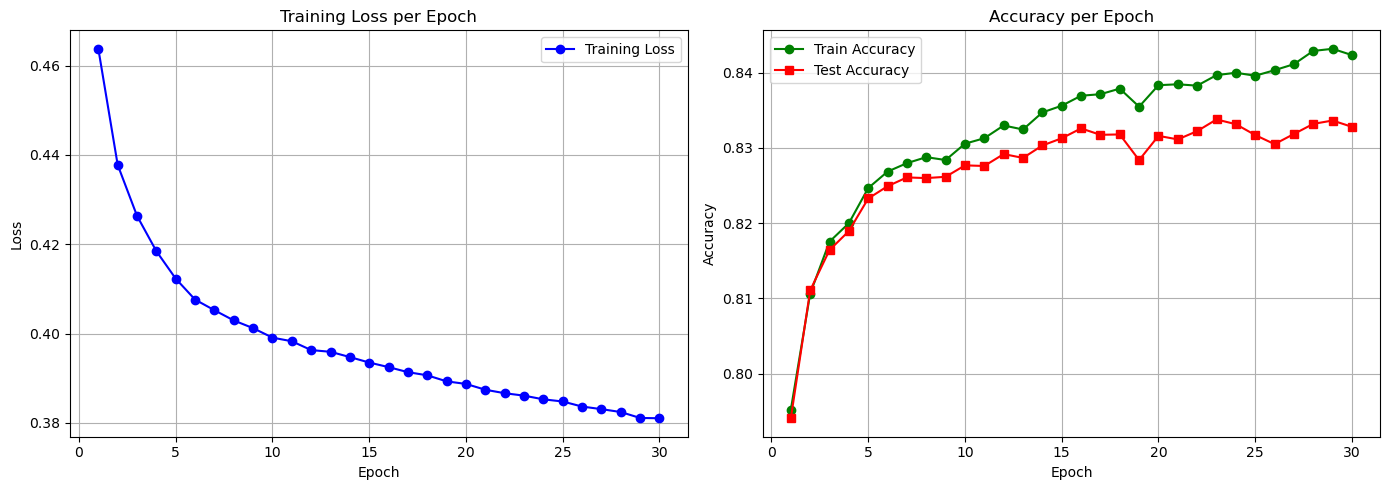

In [9]:
epochs = range(1, num_epochs + 1)
fig, axs = plt.subplots(1, 2, figsize=(14, 5))
axs[0].plot(epochs, train_losses, marker='o', linestyle='-', color='blue', label="Training Loss")
axs[0].set_xlabel("Epoch")
axs[0].set_ylabel("Loss")
axs[0].set_title("Training Loss per Epoch")
axs[0].legend()
axs[0].grid(True)
axs[1].plot(epochs, train_accs, marker='o', linestyle='-', color='green', label="Train Accuracy")
axs[1].plot(epochs, test_accs, marker='s', linestyle='-', color='red', label="Test Accuracy")
axs[1].set_xlabel("Epoch")
axs[1].set_ylabel("Accuracy")
axs[1].set_title("Accuracy per Epoch")
axs[1].legend()
axs[1].grid(True)
plt.tight_layout()
plt.show()


From the training loss plot (left), we see a steady decrease, indicating that the model is learning effectively. On the right, both training and test accuracies improve over epochs, with the training accuracy surpassing the test accuracy as expected. The model achieves over 83% test accuracy, suggesting it can meaningfully distinguish between quark and gluon jets.